<a href="https://colab.research.google.com/github/harshv47/seq2seq-Translation/blob/master/seq2seq_translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import os

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from keras.models import Model
from keras.layers import Input, CuDNNLSTM, Dense
import numpy as np

from numpy.random import seed
seed(1)

from tensorflow import set_random_seed
set_random_seed(2)

In [0]:
batch_size = 64  # Batch size for training.
epochs = 27  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '/content/drive/My Drive/Dataset/seq2seq/fra.txt'

In [0]:
df = pd.read_csv(data_path,delimiter='\t')

In [34]:
df.head(20)

,Go.,Va !
0,Run!,Cours !
1,Run!,Courez !
2,Wow!,Ça alors !
3,Fire!,Au feu !
4,Help!,À l'aide !
5,Jump.,Saute.
6,Stop!,Ça suffit !
7,Stop!,Stop !
8,Stop!,Arrête-toi !
9,Wait!,Attends !


In [35]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

# Looping over lines
lines = open(data_path).read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    # Input and target are split by tabs, English TAB French
    input_text, target_text = line.split('\t')
    
    # "\t" is the "start sequence" character and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    # set of all unique characters in the input
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
            
    # set of all unique output characters
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

print('Number of samples:', len(input_texts))

Number of samples: 10000


In [36]:
input_characters = sorted(list(input_characters)) # the order should be same in our input chars
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)

Number of unique input tokens: 71
Number of unique output tokens: 93


In [0]:
# index maps character to number
input_token_index = {char: i for i, char in enumerate(input_characters)}
target_token_index = {char: i for i, char in enumerate(target_characters)}

In [38]:
# Test for tokens
for c in 'the cat sits on the mat':
    print(input_token_index[c], end = ' ')

63 51 48 0 46 44 63 0 62 52 63 62 0 58 57 0 63 51 48 0 56 44 63 

In [39]:
max_encoder_seq_length = max([len(txt) for txt in input_texts]) # longest sequences length
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [0]:
# encoder_input_data is a 3D array of shape(num_pairs, max_english_sentence_length, num_english_characters) 
# containing a one-hot vectorization of English sentences

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')

# decoder_input_data is a 3D array of shape(num_pairs, max_french_sentence_length, num_french_characters) 
# containg a one-hot vectorization of the French sentences

decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :]
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [0]:
# Loop over input texts
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    # Loop over each char in an input text
    for t, char in enumerate(input_text):
        # Create one hot encoding by setting the index to 1
        encoder_input_data[i, t, input_token_index[char]] = 1.
    # Loop over each char in the output text
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep (,+1,)
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep (,+1,)
            # and will not include the start charcter
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [0]:

# Define an input sequence and process it
encoder_inputs = Input(shape=(None, num_encoder_tokens), 
                       name = 'encoder_inputs')

# The return_state contructor argument, configuring a RNN layer to return a list 
# where the first entry is the outputs and the next entries are the internal RNN states
# This is used to recover the states of the encoder
encoder = CuDNNLSTM(latent_dim, 
                    return_state=True, 
                    name = 'encoder')

encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state
decoder_inputs = Input(shape=(None, num_decoder_tokens), 
                       name = 'decoder_inputs')

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = CuDNNLSTM(latent_dim, 
                         return_sequences=True, 
                         return_state=True, 
                         name = 'decoder_lstm')

# The inital_state call argument, specifying the initial state(s) of a RNN 
# This is used to pass the encoder states to the decoder as initial states
# Basically making the first memory of the decoder the encoded semantics
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, 
                      activation='softmax', 
                      name = 'decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [43]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
history = model.fit([encoder_input_data, decoder_input_data], 
                    decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)
# Save model
#model.save('s2s.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/27
8000/8000 [==============================] - 3s 336us/step - loss: 0.9288 - val_loss: 0.9793
Epoch 2/27
8000/8000 [==============================] - 2s 261us/step - loss: 0.7443 - val_loss: 0.8026
Epoch 3/27
8000/8000 [==============================] - 2s 262us/step - loss: 0.6286 - val_loss: 0.7117
Epoch 4/27
8000/8000 [==============================] - 2s 261us/step - loss: 0.5679 - val_loss: 0.6596
Epoch 5/27
8000/8000 [==============================] - 2s 261us/step - loss: 0.5258 - val_loss: 0.6362
Epoch 6/27
8000/8000 [==============================] - 2s 261us/step - loss: 0.4941 - val_loss: 0.6039
Epoch 7/27
8000/8000 [==============================] - 2s 261us/step - loss: 0.4690 - val_loss: 0.5921
Epoch 8/27
8000/8000 [==============================] - 2s 261us/step - loss: 0.4476 - val_loss: 0.5714
Epoch 9/27
8000/8000 [==============================] - 2s 263us/step - loss: 0.4286 - val_loss: 0.5499
Epoch 10/27
8000

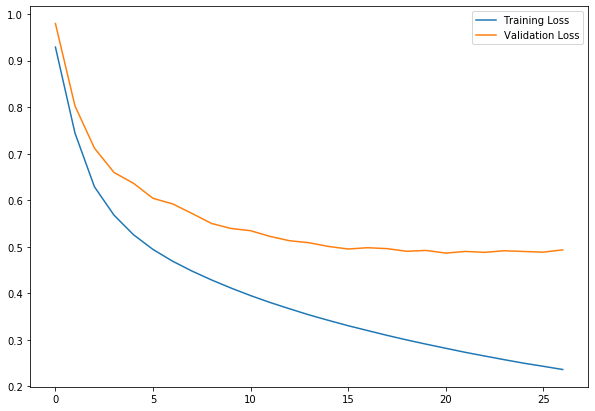

In [44]:
# The model is overfitting a bit
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
a, = plt.plot(history.history['loss'],label='Training Loss')
b, = plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(handles=[a,b])
plt.show()

In [0]:
# Define encoder model
encoder_model = Model(encoder_inputs, encoder_states)

In [0]:
# Define decoder model

# Inputs from the encoder
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

# Create a combined memory to input into the decoder
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Decoder
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

# Predict next char
decoder_outputs = decoder_dense(decoder_outputs)

# The model takes in the encoder memory plus it's own memory as an input and spits out 
# a prediction plus its own memory to be used for the next char
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [0]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = {i: char 
                            for char, i in input_token_index.items()}
reverse_target_char_index = {i: char 
                             for char, i in target_token_index.items()}

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    # Loop untilll we recieve a stop sign
    while not stop_condition:
        # Get output and internal states of the decoder 
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Get the predicted token (the token with the highest score)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # Get the character belonging to the token
        sampled_char = reverse_target_char_index[sampled_token_index]
        # Append char to output
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [0]:
test_text = 'Thanks'
placeholder = np.zeros((1,len(test_text)+10,num_encoder_tokens))

In [26]:
for i, char in enumerate(my_text):
    print(i,char, input_token_index[char])
    placeholder[0,i,input_token_index[char]] = 1

0 T 38
1 h 51
2 a 44
3 n 57
4 k 54
5 s 62


In [27]:
decode_sequence(placeholder)

'Merci !\n'